<a href="https://colab.research.google.com/github/franfgv9/Deep-Learning/blob/main/Practical_Assignment_1(Minnie%26Fran).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical Assignment 1**
# **Team: Minnie, Fran**
## Introduction
This assignment is divided into two parts. In the first part of this assignment, it is expected that you build a CNN model from scratch and evaluate it in a public dataset. In the second part, it is expected that you train and test two well-known networks and use their output for image classification, using a middle-fusion strategy.
This assignment should be done in groups of 2 students max (mandatory), and it is part of your continuous evaluation. You should provide a report, with no more than 10 pages, and a notebook (.ipynb/.py) which includes your development and analysis for the requested tasks. Structure your report in accordance with the assignment parts.

[Part 1](#scrollTo=KE2pMxUp2LeA)


[Part 2](#scrollTo=aMFMZX4a4Jdo)


# Assignment 1 Part 1

1. Modify the baseline network (Fig. 1) to reach an output mCA of at least 82% on the CIFAR-10
dataset. To accomplish this, you can:
*   add/remove convolutional layers;
*   add/remove fully-connected layers,
*   add/remove dropout or add other regularization methods;
*   add max-pooling layers;
*   modify the activation functions;
*   change the loss function and/or change the optimization method;
*   add batch normalization layers;
*   change any hyperparameter;
*   you can use an adaptive learning rate;
*   your network cannot have more than six convolutional layers;
*   add data augmentation to your dataset.

2. Implement the above-mentioned evaluation metrics to evaluate your network.
3. Gather the metrics and loss curves for four different hyperparameter combinations (learning rate, batch
size, etc)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, random_split

We set the seed so that the same results always come out (I only need to set the seed once, at the beginning of the notebook, as long as I don't restart the execution environment (the Colab kernel))

In [2]:
# Semilla
SEED = 42
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
print("Seed fixed in:", SEED)

Seed fixed in: 42


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

save_dir = "/content/drive/MyDrive/modelos_entrenados"
os.makedirs(save_dir, exist_ok=True)  # crea la carpeta si no existe

print("Safe here:", save_dir)

Safe here: /content/drive/MyDrive/modelos_entrenados


In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

# --- AUGMENTATION moderado (invarianza/robustez en CIFAR-10) ---
train_transform = T.Compose([
    T.RandomCrop(32, padding=4),    # amplia el borde de la imag con padding para luego recortar aleatoriamente una venta 32x32 --> introduce pequeñas traslaciones (desplazamientos)
    T.RandomHorizontalFlip(p=0.5),        # invierte la imag horizontlamente --> para mejorar simetrias
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),      # cambia el brillo/contraste/saturación y un poco el tono
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))       #  Los valores se publicaron hace años porque son idénticos para todo el dataset CIFAR-10, así que la comunidad los reutiliza

])

# (Nota: si quisiero normalizar por media/desv. estándar de CIFAR-10, iría aquí otro T.Normalize(...)) --> me ha faltado pero me he dado cuenta tarde (tengo los modelos ya entrenados)

# En test normalizamos tambien para trabajar tanto en train como en test en la misma escala
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                std=(0.2470, 0.2435, 0.2616))])

# En valid/test no se hacen augmentations (para medir rendimiento “real”)

# --- DATASETS + SPLIT 80/20 como en clase ---
train_full = CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_set   = CIFAR10(root="./data", train=False, download=True, transform=test_transform)

val_ratio = 0.2
n_train   = len(train_full)
n_val     = int(n_train * val_ratio)
n_tr      = n_train - n_val
train_set, val_set = torch.utils.data.random_split(train_full, [n_tr, n_val])

# --- DATALOADERS ---
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

BATCH_SIZE = 128
train_loader_model3 = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]


In [21]:
# --- ALTERNATIVE AUGMENTATION for Model 2 ---
train_transform_model2 = T.Compose([
    T.RandomCrop(32, padding=6),
    T.RandomHorizontalFlip(p=0.8),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03),
    T.ToTensor(),
    T.RandomErasing(p=0.5, scale=(0.02,0.15)),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Create a new dataset and dataloader with the alternative augmentation
train_full_model2 = CIFAR10(root="./data", train=True, download=True, transform=train_transform_model2)
# Re-split to get the same training subset indices as the original train_set
n_train_model2 = len(train_full_model2)
n_val_model2 = int(n_train_model2 * val_ratio) # Assuming val_ratio is defined earlier
n_tr_model2 = n_train_model2 - n_val_model2
train_set_model2, _ = torch.utils.data.random_split(train_full_model2, [n_tr_model2, n_val_model2]) # Discard val_set_model2 as we only need train_set_model2

BATCH_SIZE = 64
train_loader_model2 = DataLoader(train_set_model2, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)

print("Created train_loader_model2 with alternative augmentation.")

Created train_loader_model2 with alternative augmentation.


We begin by examining the structure of our dataset (CIFAR-10):

In [22]:
num_train = len(train_full)
num_test = len(test_set)
print("Number of images in original training set: " + str(num_train))
print("Number of images in original testing set: " + str(num_test))
print(f"Number of images in training set: {len(train_set)}")
print(f"Number of images in validation set: {len(val_set)}")

# Access classes and class_to_idx from the original dataset
print("Classes:", train_full.classes)
print("Map name --> index:", train_full.class_to_idx)
print()

# Label 1
img, label = train_set[0]
print("Numeric label:", label)
# Access class name from the original dataset using the label
print("Class name:", train_full.classes[label])

Number of images in original training set: 50000
Number of images in original testing set: 10000
Number of images in training set: 40000
Number of images in validation set: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Map name --> index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

Numeric label: 6
Class name: frog


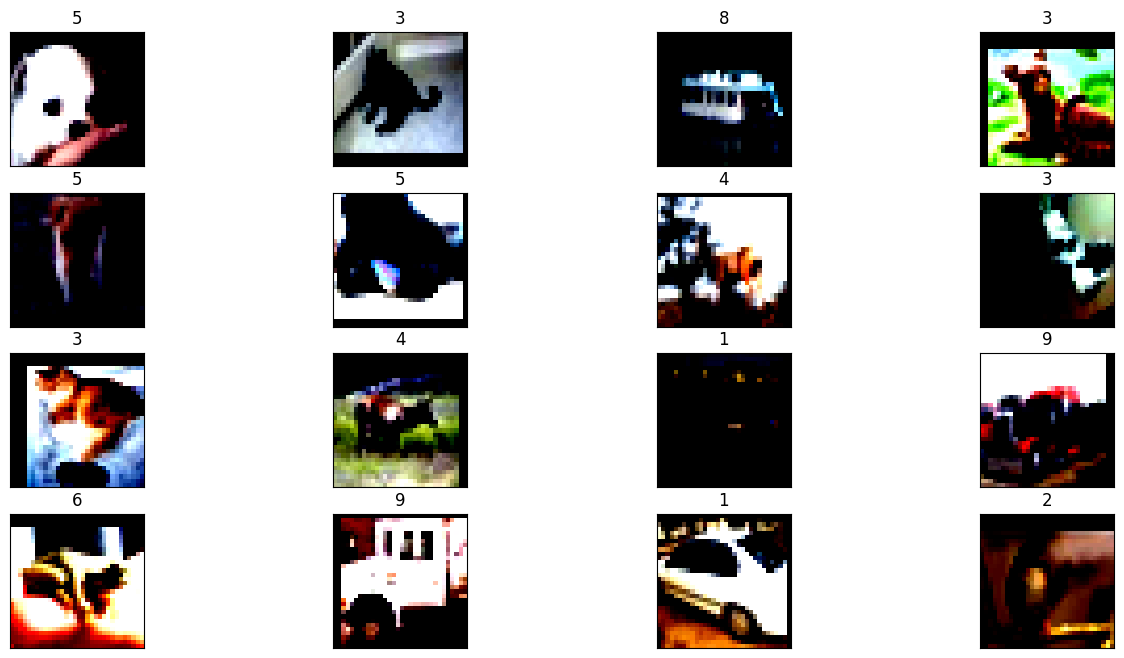

In [8]:
# Visualization of a whole batch (CIFAR-10)
import matplotlib.pyplot as plt
import numpy as np

batch_size = 16

# Get one batch from the training DataLoader
dataiter = iter(train_loader)          # convierte el DataLoader en un iterador
images, labels = next(dataiter)           # obtiene las imágenes y etiquetas del primer batch

# Plot configuration
fig = plt.figure(figsize=(16, 8))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, int(batch_size/4), idx + 1, xticks=[], yticks=[])

    # CIFAR-10: las imágenes son (3, 32, 32) → convertimos a (32, 32, 3) para imshow
    img = images[idx].permute(1, 2, 0)    # Rearranga los canales al final
    ax.imshow(img)                        # No uses cmap='gray' para RGB
    ax.set_title(str(labels[idx].item()))


# SALIDA: La resolución baja (32×32) es normal en CIFAR-10: son imágenes pequeñas, usadas para experimentos rápidos.

We can see the low-resolution images with variability affected by data augmentation. Also, we have not denormalized. If we denormalized:

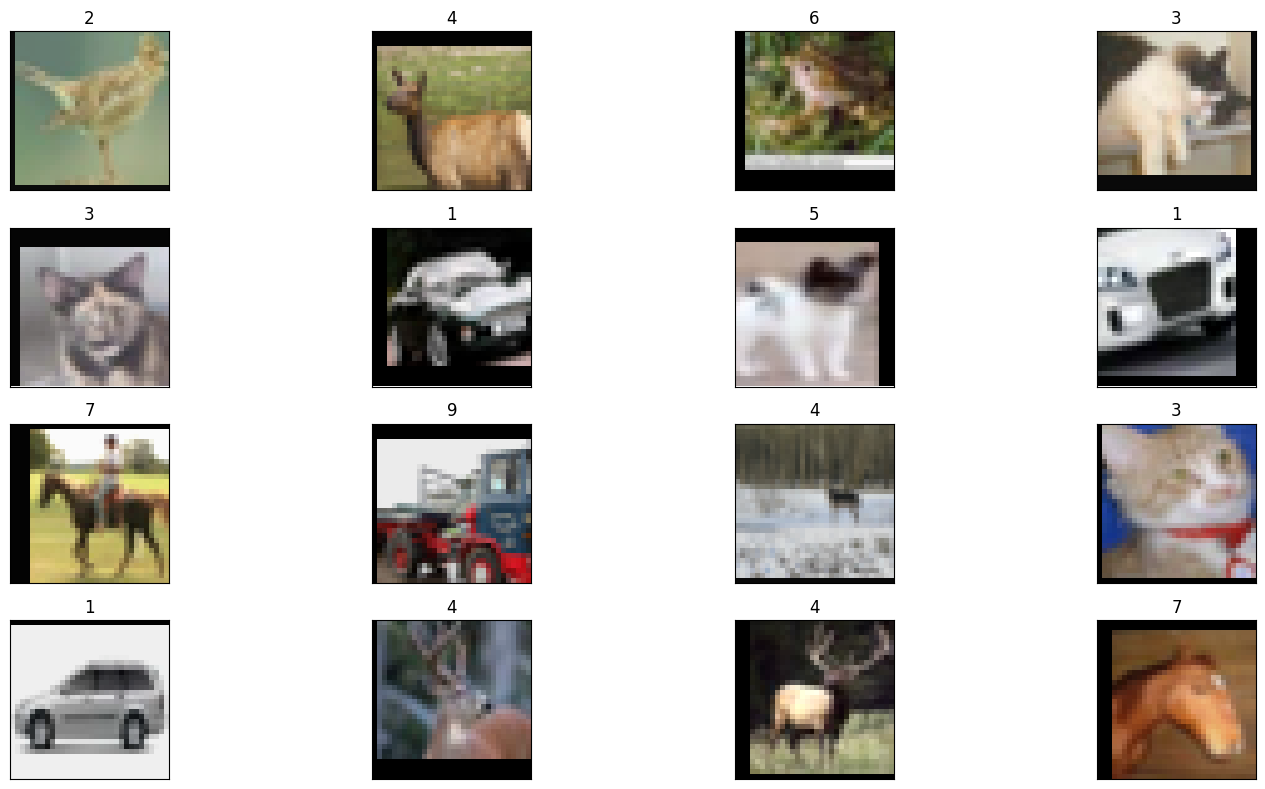

In [9]:
def denormalize(images, mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)):
    """Denormalizes a batch of images."""
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return images * std + mean

# Get one batch from the training DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize images
denorm_images = denormalize(images)

# Plot configuration
fig = plt.figure(figsize=(16, 8))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, int(batch_size/4), idx + 1, xticks=[], yticks=[])

    # CIFAR-10: las imágenes son (3, 32, 32) → convertimos a (32, 32, 3) para imshow
    img = denorm_images[idx].permute(1, 2, 0)    # Rearrange channels to the end
    ax.imshow(img)                        # Use imshow for RGB
    ax.set_title(str(labels[idx].item()))

plt.tight_layout()
plt.show()

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCifarCNN(nn.Module):
    """
    3 bloques conv: 64-128-256, kernel 3x3, BN tras cada conv, ReLU, MaxPool tras bloque.
    Cabeza: Flatten -> FC(256) -> Dropout(0.35) -> FC(10)
    """
    def __init__(self, num_classes=10, p_drop=0.35):
        super().__init__()
        # Bloque 1: 3 -> 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),             # normaliza la salida de cada canal → acelera y estabiliza el entrenamiento
            nn.ReLU(inplace=True),          # activación no lineal (sólo deja pasar valores positivos)
            nn.MaxPool2d(2)  # 32->16       #reduce el tamaño espacial a la mitad
        )
        # Bloque 2: 64 -> 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16->8
        )
        # Bloque 3: 128 -> 256
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8->4
        )

        # Cabeza compacta
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 4 * 4, 256, bias=False)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p_drop)
        self.fc2 = nn.Linear(256, num_classes, bias=True)

        # He init (Kaiming) + bias=0 --> Inicialización de pesos personalizada segun el bloque
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):          # Si la capa es Convolucional o Lineal, inicializa sus pesos con He Normal (Kaiming)
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if getattr(m, "bias", None) is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):             # Si es BatchNorm, se inicializan los parámetros de escala y sesgo:    gamma (peso) = 1 → no altera la varianza inicial     beta (bias) = 0 → sin desplazamiento inicial
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.conv1(x)   # [B,64,16,16]
        x = self.conv2(x)   # [B,128,8,8]
        x = self.conv3(x)   # [B,256,4,4]
        x = self.flatten(x) # [B, 4096]
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.drop(x)
        x = self.fc2(x)     # [B,10]
        return x


In [25]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCifarCNN(num_classes=10, p_drop=0.35).to(device)       # dropout = [0.35, 0.6]  --> para hacer sanity check

criterion = nn.CrossEntropyLoss()

# LR en el rango pedido (puedes probar 3e-4, 5e-4, 1e-3 en tus 4 runs)
START_LR = 5e-4
# Change optimizer to SGD with momentum and Nesterov
optimizer = optim.Adam(model.parameters(), lr=START_LR)
# optimizer = optim.SGD(model.parameters(), lr=START_LR, momentum=0.9, nesterov=True)


# --- SCHEDULER: elige uno: 'step' o 'cosine' ---
SCHED = 'step'  # 'step' o 'cosine'
EPOCHS = 2

if SCHED == 'step':
    # baja el LR cada 15 épocas (gamma=0.5 simple)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
elif SCHED == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
else:
    scheduler = None

SANITY CHECK:

1. This way we can see that the model trains differently when you regularize (regularization affects learning).
2. We also see that the training loss at the beginning is reasonable at 1.57 (without NaN, Inf, or values very low below 0.1 or very high above 10) --> this indicates that there is a reasonable loss at the beginning and therefore everything is in order.
3. Overfit a small subdataset to check that the architecture, gradients, and initialization are working.

Sanity check 1 y 2

In [26]:
# 4) Bucle de train/val + Train Loss
def _epoch_pass(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total, correct = 0, 0
    loss_sum = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        # métricas sencillas
        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc

In [ ]:
best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    train_loss, train_acc = _epoch_pass(model, train_loader, optimizer)
    # --- Validation ---
    val_loss, val_acc = _epoch_pass(model, val_loader, optimizer=None)

    # Scheduler
    if scheduler is not None:
        scheduler.step()

    # --- Print estilo práctica ---
    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Valid Loss: {val_loss:.4f} | "
          f"Valid Acc: {val_acc*100:.2f}%")

print("Training completed successfully!")

Epoch [1/2] Train Loss: 1.7386 | Train Acc: 37.90% | Valid Loss: 1.5581 | Valid Acc: 44.35%
Epoch [2/2] Train Loss: 1.3301 | Train Acc: 52.15% | Valid Loss: 1.2975 | Valid Acc: 53.88%
✅ Training completed successfully!


If we increase the dropout, the training loss increases --> regularization works (validity check 1)

Training loss = 1.73 --> reasonable (validity check 2)

Sanity check 3 (overfit a subdataset)

In [27]:
# ==== SANITY CHECK 3: Overfit a un subconjunto diminuto (100 imágenes) ====
# Objetivo: demostrar que la red puede memorizar 100 imágenes (~100% train acc)
# Configuración: sin augmentations, sin weight decay, Dropout=0 temporalmente, LR=1e-3

import torch
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

# 1) Dataset diminuto SIN augmentations
def make_tiny_loader(n=100, seed=42):
    base = CIFAR10(root="./data", train=True, download=True, transform=T.ToTensor())
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(len(base), generator=g)[:n].tolist()
    tiny = Subset(base, idx)
    return DataLoader(tiny, batch_size=n, shuffle=True, num_workers=2, pin_memory=True)

tiny_loader = make_tiny_loader(n=100, seed=42)

# 2) Desactivar regularización para facilitar la memorización
#    - Dropout a 0 (temporal) si existe self.drop
try:
    _orig_p = model.drop.p
    model.drop.p = 0.0
except AttributeError:
    _orig_p = None

#    - Optimizador sin weight decay, LR razonable
optim_overfit = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)

# 3) Entrenar SOLO sobre el miniset hasta ~100% acc (no hay valid aquí)
MAX_EPOCHS_TINY = 300
TARGET_ACC = 0.999  # ~100%

for ep in range(1, MAX_EPOCHS_TINY + 1):
    train_loss, train_acc = _epoch_pass(model, tiny_loader, optimizer=optim_overfit)
    print(f"[Tiny {ep:03d}/{MAX_EPOCHS_TINY}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    if train_acc >= TARGET_ACC:
        print("Overfitting achieved: ~100% accuracy on the small subset.")
        break

# 4) Restaurar Dropout original (si procede)
if _orig_p is not None:
    model.drop.p = _orig_p

# Nota: Este bloque NO guarda el modelo; es solo un test de capacidad de memorización.
# Tras el sanity check, vuelve a tu entrenamiento normal con augmentations y dropout>0


[Tiny 001/300] Train Loss: 2.7032 | Train Acc: 10.70%
[Tiny 002/300] Train Loss: 1.8298 | Train Acc: 41.40%
[Tiny 003/300] Train Loss: 1.3401 | Train Acc: 55.40%
[Tiny 004/300] Train Loss: 1.0997 | Train Acc: 64.30%
[Tiny 005/300] Train Loss: 0.8987 | Train Acc: 74.30%
[Tiny 006/300] Train Loss: 0.7261 | Train Acc: 81.80%
[Tiny 007/300] Train Loss: 0.6054 | Train Acc: 86.20%
[Tiny 008/300] Train Loss: 0.4995 | Train Acc: 90.80%
[Tiny 009/300] Train Loss: 0.4076 | Train Acc: 94.40%
[Tiny 010/300] Train Loss: 0.3255 | Train Acc: 96.80%
[Tiny 011/300] Train Loss: 0.2586 | Train Acc: 98.20%
[Tiny 012/300] Train Loss: 0.2100 | Train Acc: 99.10%
[Tiny 013/300] Train Loss: 0.1721 | Train Acc: 99.50%
[Tiny 014/300] Train Loss: 0.1393 | Train Acc: 100.00%
Overfitting achieved: ~100% accuracy on the small subset.


After the three sanity checks, we are ready to train a model with the complete dataset. We have chosen the hyperparameters well, and the model works correctly.

Now let's train the complete model:

In [28]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCifarCNN(num_classes=10, p_drop=0.35).to(device)

criterion = nn.CrossEntropyLoss()

# LR en el rango pedido (puedes probar 3e-4, 5e-4, 1e-3 en tus 4 runs)
START_LR = 5e-3
optimizer = optim.Adam(model.parameters(), lr=START_LR)
# optimizer = optim.SGD(model.parameters(), lr=START_LR, momentum=0.9, nesterov=True)

# --- SCHEDULER: elige uno: 'step' o 'cosine' ---
SCHED = 'step'  # 'step' o 'cosine'
EPOCHS = 15

if SCHED == 'step':
    # baja el LR cada 15 épocas (gamma=0.5 simple)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
elif SCHED == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
else:
    scheduler = None


In [ ]:
train_losses = []
val_losses = []

best_val_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    train_loss, train_acc = _epoch_pass(model, train_loader, optimizer)
    # --- Validation ---
    val_loss, val_acc = _epoch_pass(model, val_loader, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Scheduler
    if scheduler is not None:
        scheduler.step()

    # Guardar mejor modelo --> va actualizando en cada epoch para quedarse finalmente con el mejor
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(),
                   f"{save_dir}/arquitectura_base_CIFAR_10_best_state_c2.pt")

    # --- Print estilo práctica ---
    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | "
          f"Valid Loss: {val_loss:.4f} | "
          f"Valid Acc: {val_acc*100:.2f}%")

print("Training completed successfully!")

# Save the loss history
loss_history = {
    'train_losses': train_losses,
    'val_losses': val_losses
}
torch.save(loss_history, f"{save_dir}/arquitectura_base_CIFAR_10_loss_history_c2.pt")
print(f"Loss history saved to {save_dir}/arquitectura_base_CIFAR_10_loss_history_c2.pt")

Epoch [1/15] Train Loss: 1.3116 | Train Acc: 52.70% | Valid Loss: 1.1381 | Valid Acc: 59.73%
Epoch [2/15] Train Loss: 1.0363 | Train Acc: 63.09% | Valid Loss: 1.1159 | Valid Acc: 61.34%
Epoch [3/15] Train Loss: 0.9149 | Train Acc: 67.89% | Valid Loss: 0.9160 | Valid Acc: 67.74%
Epoch [4/15] Train Loss: 0.8349 | Train Acc: 70.56% | Valid Loss: 1.1288 | Valid Acc: 62.58%
Epoch [5/15] Train Loss: 0.7694 | Train Acc: 73.13% | Valid Loss: 0.8462 | Valid Acc: 70.06%
Epoch [6/15] Train Loss: 0.7387 | Train Acc: 74.00% | Valid Loss: 0.9899 | Valid Acc: 67.37%
Epoch [7/15] Train Loss: 0.6968 | Train Acc: 75.62% | Valid Loss: 0.9342 | Valid Acc: 69.59%
Epoch [8/15] Train Loss: 0.6661 | Train Acc: 76.85% | Valid Loss: 0.7156 | Valid Acc: 74.70%
Epoch [9/15] Train Loss: 0.6348 | Train Acc: 77.70% | Valid Loss: 0.7171 | Valid Acc: 75.38%
Epoch [10/15] Train Loss: 0.6120 | Train Acc: 78.73% | Valid Loss: 0.7176 | Valid Acc: 75.03%
Epoch [11/15] Train Loss: 0.5998 | Train Acc: 79.23% | Valid Loss: 0.

Metrics (mCA/F1/Precision/Recall + Confusion Matrix) with scikit-learn

In [29]:
import numpy as np
import torch
from sklearn.metrics import (
    balanced_accuracy_score,  # = mCA
    classification_report,    # saca Precision/Recall/F1 (macro)
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

@torch.no_grad()
def _collect_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        y_pred.append(logits.argmax(1).cpu().numpy())
        y_true.append(y.numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

def eval_with_sklearn(model, loader, split_name="val"):     # split_name solo se usa para los títulos/prints
    y_true, y_pred = _collect_preds(model, loader)

    # mCA = balanced accuracy (mean recall over classes)
    mca = balanced_accuracy_score(y_true, y_pred)

    # Precision/Recall/F1 macro (macro avg del classification_report)
    report = classification_report(y_true, y_pred, output_dict=True)
    prec_macro = report["macro avg"]["precision"]
    rec_macro  = report["macro avg"]["recall"]                                  # Extrae los promedios macro (media simple sobre clases, todas pesan igual)
    f1_macro   = report["macro avg"]["f1-score"]


    print(f"\n=== {split_name.upper()} METRICS (scikit-learn) ===")
    print(f"mCA (balanced accuracy): {mca*100:.2f}%")
    print(f"F1-macro: {f1_macro*100:.2f}% | "                             # Muestra las métricas en porcentaje con 2 decimales
          f"Precision-macro: {prec_macro*100:.2f}% | "
          f"Recall-macro: {rec_macro*100:.2f}%")

    # Matriz de confusión (normal/absoluta)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap="Blues", colorbar=True)
    ax.set_title(f"Confusion Matrix ({split_name})")
    plt.tight_layout()
    plt.show()

    return {"mca": mca, "f1_macro": f1_macro, "precision_macro": prec_macro,
            "recall_macro": rec_macro, "cm": cm}



--- Evaluating model from arquitectura_base_CIFAR_10_best_state_c4.pt ---
Train Loss: 0.4652 | Train Acc: 83.67%
Valid Loss: 0.4603 | Valid Acc: 83.86%

=== TEST - ARQUITECTURA_BASE_CIFAR_10_BEST_STATE_C4.PT METRICS (scikit-learn) ===
mCA (balanced accuracy): 82.50%
F1-macro: 82.39% | Precision-macro: 82.72% | Recall-macro: 82.50%


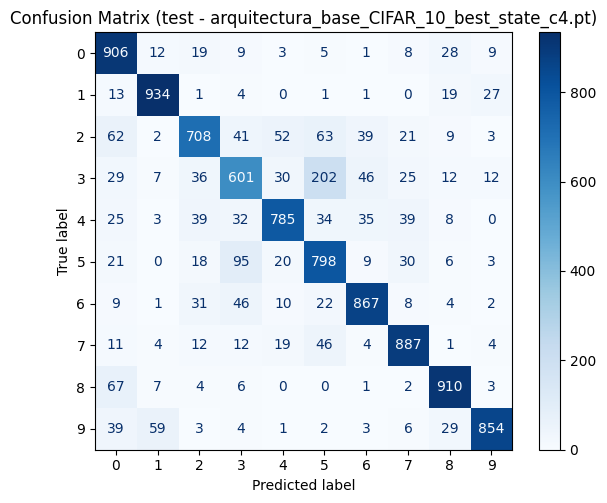

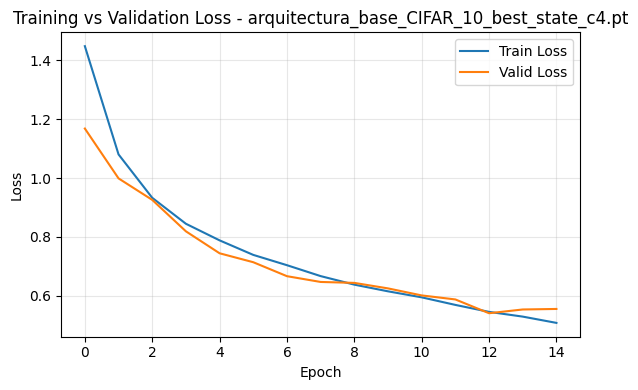


--- Evaluating model from arquitectura_base_CIFAR_10_best_state_c2.pt ---
Note: Using train_loader_model2 for arquitectura_base_CIFAR_10_best_state_c2.pt
Train Loss: 0.6353 | Train Acc: 77.81%
Valid Loss: 0.4876 | Valid Acc: 82.46%

=== TEST - ARQUITECTURA_BASE_CIFAR_10_BEST_STATE_C2.PT METRICS (scikit-learn) ===
mCA (balanced accuracy): 80.77%
F1-macro: 80.91% | Precision-macro: 81.64% | Recall-macro: 80.77%


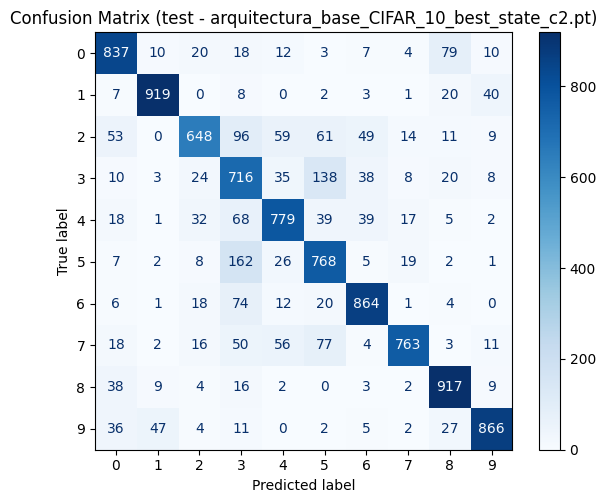

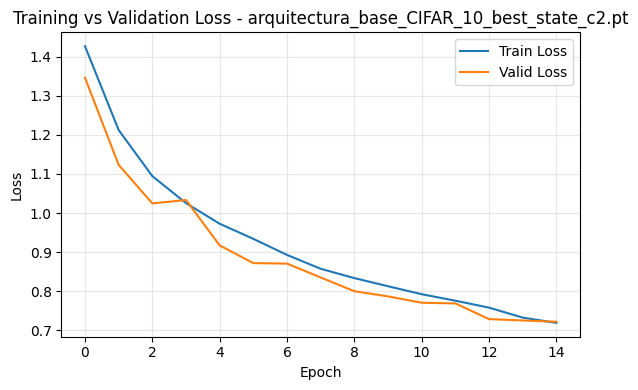


--- Evaluating model from arquitectura_base_CIFAR_10_best_state_c3.pt ---
Train Loss: 0.4402 | Train Acc: 84.96%
Valid Loss: 0.4274 | Valid Acc: 85.51%

=== TEST - ARQUITECTURA_BASE_CIFAR_10_BEST_STATE_C3.PT METRICS (scikit-learn) ===
mCA (balanced accuracy): 83.32%
F1-macro: 83.25% | Precision-macro: 83.23% | Recall-macro: 83.32%


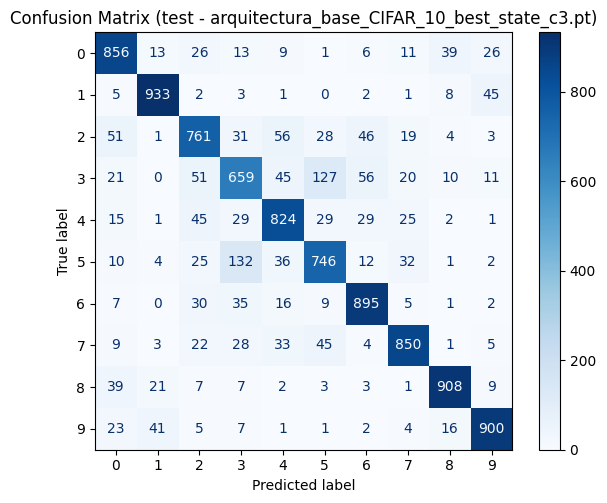

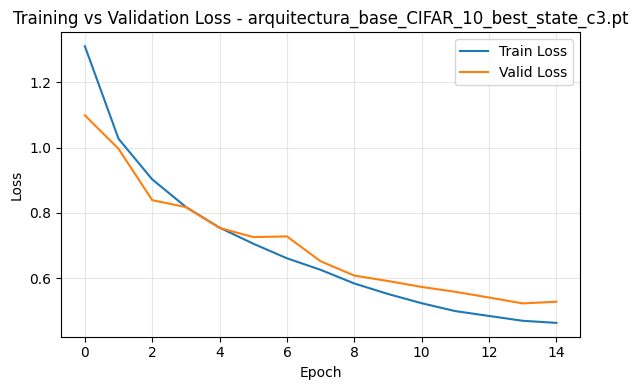


--- Evaluating model from arquitectura_base_CIFAR_10_best_state_c1.pt ---
Train Loss: 0.3103 | Train Acc: 89.35%
Valid Loss: 0.3059 | Valid Acc: 89.12%

=== TEST - ARQUITECTURA_BASE_CIFAR_10_BEST_STATE_C1.PT METRICS (scikit-learn) ===
mCA (balanced accuracy): 86.18%
F1-macro: 86.16% | Precision-macro: 86.16% | Recall-macro: 86.18%


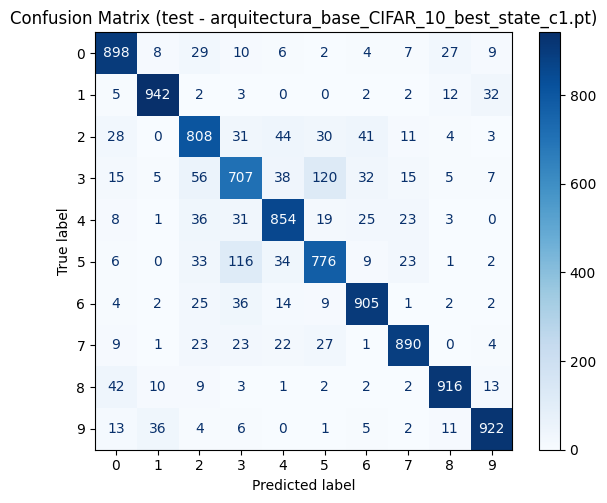

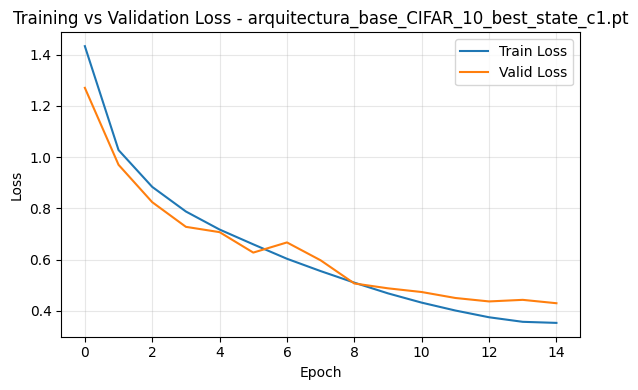


All models evaluated successfully!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of checkpoints to load and evaluate
checkpoint_files = [
    "arquitectura_base_CIFAR_10_best_state_c4.pt",
    "arquitectura_base_CIFAR_10_best_state_c2.pt",
    "arquitectura_base_CIFAR_10_best_state_c3.pt",
    "arquitectura_base_CIFAR_10_best_state_c1.pt" # Include the first model trained as well
]

# Dictionary to map checkpoint files to their respective dropout values
dropout_map = {
    "arquitectura_base_CIFAR_10_best_state_c1.pt": 0.30,
    "arquitectura_base_CIFAR_10_best_state_c2.pt": 0.35,
    "arquitectura_base_CIFAR_10_best_state_c3.pt": 0.25,
    "arquitectura_base_CIFAR_10_best_state_c4.pt": 0.25,
}


model_results = {}

for checkpoint_file in checkpoint_files:
    print(f"\n--- Evaluating model from {checkpoint_file} ---")
    # 1. Instantiate the same architecture with the correct dropout
    p_drop = dropout_map.get(checkpoint_file, 0.30) # Default to 0.30 if not found
    model = SimpleCifarCNN(num_classes=10, p_drop=p_drop).to(device)


    # 2. Load the trained weights
    state_dict = torch.load(f"{save_dir}/{checkpoint_file}", map_location=device)
    model.load_state_dict(state_dict)

    # 3. Put the model in evaluation mode
    model.eval()

    # Load the loss history
    loss_history_file = checkpoint_file.replace("best_state", "loss_history")
    try:
        loss_history = torch.load(f"{save_dir}/{loss_history_file}")
        train_losses = loss_history['train_losses']
        val_losses = loss_history['val_losses']
    except FileNotFoundError:
        print(f"Warning: Loss history file {loss_history_file} not found.")
        train_losses = []
        val_losses = []

    # Select the appropriate train loader based on the model checkpoint
    current_train_loader = train_loader
    if checkpoint_file == "arquitectura_base_CIFAR_10_best_state_c2.pt":
        # Assuming train_loader_model2 is the DataLoader with the specific augmentation for model 2
        current_train_loader = train_loader_model2
        print(f"Note: Using train_loader_model2 for {checkpoint_file}")

    if checkpoint_file == "arquitectura_base_CIFAR_10_best_state_c3.pt":
        # Assuming train_loader_model3 is the DataLoader with the specific augmentation for model 3
        current_train_loader = train_loader_model3

    # Evaluate on training set
    train_loss, train_acc = _epoch_pass(model, current_train_loader, optimizer=None)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

    # Evaluate on validation set
    val_loss, val_acc = _epoch_pass(model, val_loader, optimizer=None)
    print(f"Valid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")

    # Evaluate on test set and collect metrics
    test_stats = eval_with_sklearn(model, test_loader, split_name=f"test - {checkpoint_file}")


    model_results[checkpoint_file] = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "test_stats": test_stats,
        "train_losses_hist": train_losses,
        "val_losses_hist": val_losses
    }

    # Plot loss curves
    if train_losses and val_losses:
        plt.figure(figsize=(6,4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses,   label="Valid Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Training vs Validation Loss - {checkpoint_file}")
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
    else:
        print(f"Skipping loss curve plot for {checkpoint_file} due to missing history.")


print("\nAll models evaluated successfully!")

We finally graph the best model again --> c1 model

In [ ]:
#  1. Instanciar la misma arquitectura
model = SimpleCifarCNN(num_classes=10, p_drop=0.3).to(device)

# 2. Cargar el diccionario de pesos entrenados
state_dict = torch.load(f"{save_dir}/arquitectura_base_CIFAR_10_best_state_c1.pt",
                        map_location=device)

model.load_state_dict(state_dict)

# 3. Poner el modelo en modo evaluación
model.eval()

# Load the loss history
loss_history = torch.load(f"{save_dir}/arquitectura_base_CIFAR_10_loss_history_c1.pt")
train_losses = loss_history['train_losses']
val_losses = loss_history['val_losses']

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 0.3165 | Train Acc: 89.17%



=== TEST METRICS (scikit-learn) ===
mCA (balanced accuracy): 86.20%
F1-macro: 86.18% | Precision-macro: 86.17% | Recall-macro: 86.20%


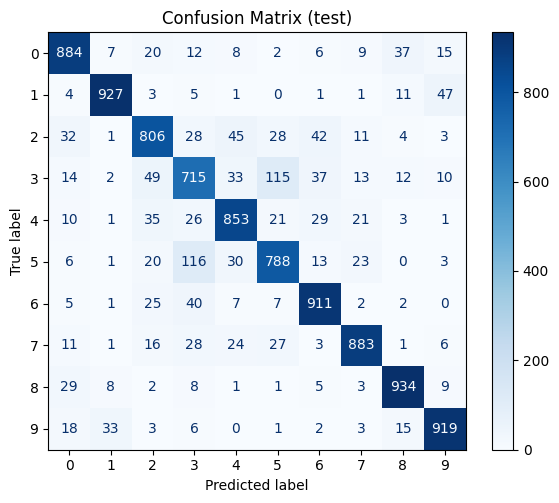

In [ ]:
test_stats = eval_with_sklearn(model, test_loader, split_name="test")

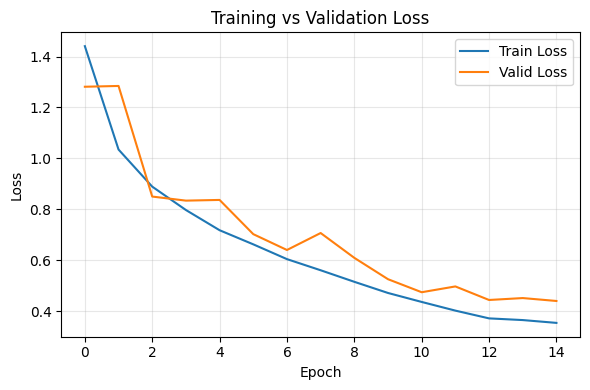

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Valid Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()



---



# Assignment 1 Part 2 #
1. Implement in your code one ResNet model (18, 34, 50, 101 or 152) and one MobileNet V3 (small or large) model (you can import the networks from PyTorch - torchvision.models3 or timm4). Take into account your computational resources in this step, as well as the implications of this choice e.g., choosing one complex architecture in detriment of a simpler architecture, for this specific dataset;
2. Define a training/validation split for the STL-10 dataset (e.g., 80/20);
3. Train both networks you selected from scratch (both networks should be trained using the same
training hyperparameters);
3. Train both networks using, as a starting point, the publicly available pretrained model of the network you are using, in most cases it will be an ImageNet-trained model (check torchvision or timm pretrained weights);
4. Using the two best trained models (one ResNet and one MobileNetV3) implement a middle fusion technique. You should create a new network that combines the feature maps from the two different models, and create a new classification layer that takes as input the feature maps. The feature maps can be aggregated or concatenated. For each model you should freeze the feature extraction weights (otherwise explain why).
5. IMPORTANT: Implement the aforementioned evaluation metrics to evaluate your networks and the chosen middle fusion (check sklearn);
6. IMPORTANT: Gather the metrics and loss curves for all training conditions.
*  Tip: To avoid Colab virtual machine connection issues, save your models after the training phase is completed. To save your CNN models, you can save them on your Google Drive or download them to your machine.

In [ ]:
import torch
from torchvision.datasets import STL10
import torchvision.transforms as tt

transform = tt.ToTensor()
training_data = STL10(root='./data', split='train', download=True, transform=transform)
testing_data = STL10(root='./data', split='test', download=True, transform=transform)
train_set , val_set = torch.utils.data.random_split(training_data , [int(len(training_data)*0.8), int(
len(training_data)*0.2)])

100%|██████████| 2.64G/2.64G [01:23<00:00, 31.6MB/s]


In [ ]:
print("train size:", len(train_set), "val size:", len(val_set), "test size:", len(testing_data))

train size: 4000 val size: 1000 test size: 8000


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time
from torchvision import models

In [ ]:
# STL10 has 10 classes, let's print them to be sure
print("classes:", training_data.classes)  # we want to know what index maps to which class

# check one sample
img0, y0 = training_data[0]
print("one sample tensor shape :", img0.shape)  # should be [C,H,W]
print("one sample label (index) :", y0, ":", training_data.classes[y0])


classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
one sample tensor shape : torch.Size([3, 96, 96])
one sample label (index) : 1 : bird


batch tensor shape : torch.Size([16, 3, 96, 96])


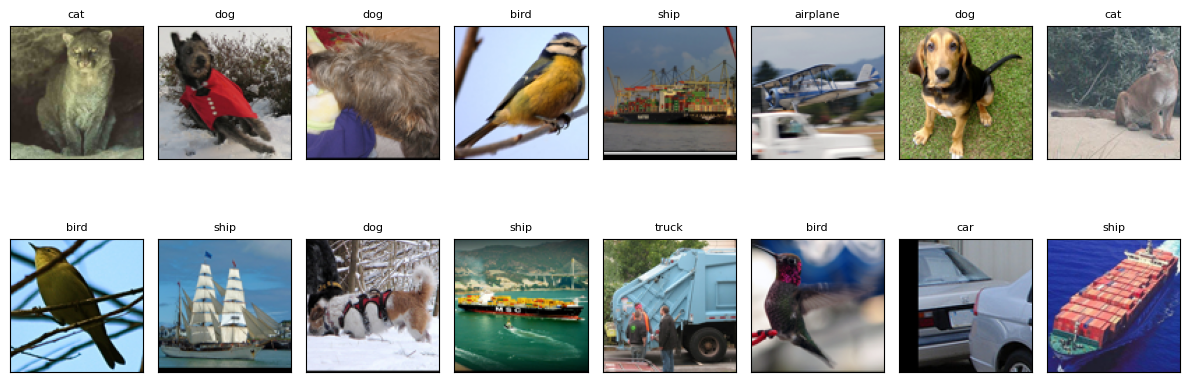

In [ ]:
# We wanna see the pic
batch_size = 16
train_loader_preview = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# grab one batch
imgs, labels = next(iter(train_loader_preview))
print("batch tensor shape :", imgs.shape)  # we want [B, C, H, W]

# plot the whole batch
fig = plt.figure(figsize=(12, 5))
for i in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, i+1, xticks=[], yticks=[])
    # we didn’t normalize yet
    img_np = imgs[i].permute(1,2,0).numpy()
    img_np = np.clip(img_np, 0, 1)  # ToTensor() already scales to [0,1]
    ax.imshow(img_np)
    ax.set_title(training_data.classes[labels[i].item()], fontsize=8)
plt.tight_layout(); plt.show()


In [ ]:
# We should resize the data,bcz pretrained model base on 224*224 not 96*96. Keeping same,now do resize and Normalize
IMG_SIZE = 224
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

train_tf = tt.Compose([
    tt.Resize((IMG_SIZE, IMG_SIZE)),
    tt.RandomHorizontalFlip(p=0.5),  # we want a tiny bit of aug
    tt.ToTensor(),
    tt.Normalize(IMNET_MEAN, IMNET_STD),  # we keep it same for scratch & pretrained
])
eval_tf = tt.Compose([
    tt.Resize((IMG_SIZE, IMG_SIZE)),
    tt.ToTensor(),
    tt.Normalize(IMNET_MEAN, IMNET_STD),
])

In [ ]:
# transform data
training_data.transform = train_tf
testing_data.transform  = eval_tf

In [ ]:
# bulid DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(testing_data, batch_size=batch_size, shuffle=False)

num_classes = 10

# we want to see 224 now
imgs, _ = next(iter(train_loader))
print("batch shape :", imgs.shape)  # expect [16, 3, 224, 224]

batch shape : torch.Size([16, 3, 224, 224])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('\nThe model will run on', device)


The model will run on cuda


In [ ]:
# Define train and validate model (select best by Val Acc)
def train_model(model, optimizer, train_loader, val_loader, epochs=10, name="model"):
    criterion = nn.CrossEntropyLoss()
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    best_metric = -1.0       # we want to track the best val metric (here: Val Acc)
    best_state = None        # to store the best weights (by validation)
    best_epoch = -1

    for epoch in range(epochs):
        # train
        model.train()
        total, correct, train_loss_sum = 0, 0, 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_losses.append(train_loss_sum / len(train_loader))
        train_accs.append(correct / total)

        # validate
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss_sum += loss.item()
                pred = out.argmax(1)
                val_correct += (pred == y).sum().item()
                val_total += y.size(0)

        val_loss = val_loss_sum / len(val_loader)
        val_acc  = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # we want to keep the best epoch (by Val Acc) as our checkpoint
        if val_acc > best_metric:
            best_metric = val_acc
            best_epoch = epoch + 1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        print(f"[{name}] Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_accs[-1]:.3f} | Val Acc: {val_accs[-1]:.3f} "
              f"| Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    # load the best weights before returning
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        print(f"[{name}] Loaded best weights from epoch {best_epoch} (Val Acc={best_metric:.3f}).")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_epoch": best_epoch,
        "best_val_acc": best_metric,
        "best_state": best_state,
    }


In [ ]:
# Define ResNet18 (scratch)
resnet_scratch = models.resnet18(weights=None)
resnet_scratch.fc = nn.Linear(resnet_scratch.fc.in_features, num_classes)
resnet_scratch = resnet_scratch.to(device)

# Define MobileNetV3-small (scratch)
mobilenet_scratch = models.mobilenet_v3_small(weights=None)
mobilenet_scratch.classifier[3] = nn.Linear(
    mobilenet_scratch.classifier[3].in_features, num_classes
)
mobilenet_scratch = mobilenet_scratch.to(device)

In [ ]:
# train ResNet18 (scratch)
optimizer_r_s = optim.Adam(resnet_scratch.parameters(), lr=1e-4)
res_hist = train_model(
    resnet_scratch, optimizer_r_s, train_loader, val_loader,
    epochs=10, name="ResNet_scratch"
)
torch.save(res_hist["best_state"], "best_resnet18_scratch.pth")  # we want to keep the best

# train MobileNetV3-small (scratch)
optimizer_m_s = optim.Adam(mobilenet_scratch.parameters(), lr=1e-4)
mob_hist = train_model(
    mobilenet_scratch, optimizer_m_s, train_loader, val_loader,
    epochs=10, name="MobileNet_scratch"
)
torch.save(mob_hist["best_state"], "best_mobilenetv3s_scratch.pth")

[ResNet_scratch] Epoch [1/10] Train Acc: 0.334 | Val Acc: 0.411 | Train Loss: 1.7331 | Val Loss: 1.5278
[ResNet_scratch] Epoch [2/10] Train Acc: 0.461 | Val Acc: 0.462 | Train Loss: 1.4326 | Val Loss: 1.4365
[ResNet_scratch] Epoch [3/10] Train Acc: 0.539 | Val Acc: 0.471 | Train Loss: 1.2445 | Val Loss: 1.4076
[ResNet_scratch] Epoch [4/10] Train Acc: 0.598 | Val Acc: 0.541 | Train Loss: 1.0992 | Val Loss: 1.2381
[ResNet_scratch] Epoch [5/10] Train Acc: 0.655 | Val Acc: 0.549 | Train Loss: 0.9437 | Val Loss: 1.2949
[ResNet_scratch] Epoch [6/10] Train Acc: 0.709 | Val Acc: 0.536 | Train Loss: 0.8244 | Val Loss: 1.3931
[ResNet_scratch] Epoch [7/10] Train Acc: 0.753 | Val Acc: 0.548 | Train Loss: 0.7058 | Val Loss: 1.4430
[ResNet_scratch] Epoch [8/10] Train Acc: 0.808 | Val Acc: 0.552 | Train Loss: 0.5692 | Val Loss: 1.3603
[ResNet_scratch] Epoch [9/10] Train Acc: 0.851 | Val Acc: 0.561 | Train Loss: 0.4626 | Val Loss: 1.3251
[ResNet_scratch] Epoch [10/10] Train Acc: 0.893 | Val Acc: 0.616

In [ ]:
# ResNet18 (pretrained)
resnet_pre = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_pre.fc = nn.Linear(resnet_pre.fc.in_features, num_classes)
resnet_pre = resnet_pre.to(device)
opt_r_p = optim.Adam(resnet_pre.parameters(), lr=1e-4)
res_pre_hist = train_model(resnet_pre, opt_r_p, train_loader, val_loader, epochs=10, name="ResNet_pretrained")
torch.save(res_pre_hist["best_state"], "best_resnet18_pretrained.pth")

# MobileNetV3-small (pretrained)
mobilenet_pre = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
mobilenet_pre.classifier[3] = nn.Linear(mobilenet_pre.classifier[3].in_features, num_classes)
mobilenet_pre = mobilenet_pre.to(device)
opt_m_p = optim.Adam(mobilenet_pre.parameters(), lr=1e-4)
mob_pre_hist = train_model(mobilenet_pre, opt_m_p, train_loader, val_loader, epochs=10, name="MobileNet_pretrained")
torch.save(mob_pre_hist["best_state"], "best_mobilenetv3s_pretrained.pth")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


[ResNet_pretrained] Epoch [1/10] Train Acc: 0.858 | Val Acc: 0.930 | Train Loss: 0.4930 | Val Loss: 0.2103
[ResNet_pretrained] Epoch [2/10] Train Acc: 0.954 | Val Acc: 0.943 | Train Loss: 0.1632 | Val Loss: 0.1635
[ResNet_pretrained] Epoch [3/10] Train Acc: 0.977 | Val Acc: 0.946 | Train Loss: 0.0897 | Val Loss: 0.1511
[ResNet_pretrained] Epoch [4/10] Train Acc: 0.982 | Val Acc: 0.942 | Train Loss: 0.0645 | Val Loss: 0.1710
[ResNet_pretrained] Epoch [5/10] Train Acc: 0.988 | Val Acc: 0.958 | Train Loss: 0.0455 | Val Loss: 0.1512
[ResNet_pretrained] Epoch [6/10] Train Acc: 0.987 | Val Acc: 0.941 | Train Loss: 0.0495 | Val Loss: 0.1629
[ResNet_pretrained] Epoch [7/10] Train Acc: 0.988 | Val Acc: 0.934 | Train Loss: 0.0429 | Val Loss: 0.2093
[ResNet_pretrained] Epoch [8/10] Train Acc: 0.992 | Val Acc: 0.954 | Train Loss: 0.0328 | Val Loss: 0.1535
[ResNet_pretrained] Epoch [9/10] Train Acc: 0.990 | Val Acc: 0.929 | Train Loss: 0.0369 | Val Loss: 0.1998
[ResNet_pretrained] Epoch [10/10] Tra

100%|██████████| 9.83M/9.83M [00:00<00:00, 119MB/s]


[MobileNet_pretrained] Epoch [1/10] Train Acc: 0.741 | Val Acc: 0.900 | Train Loss: 0.9080 | Val Loss: 0.3532
[MobileNet_pretrained] Epoch [2/10] Train Acc: 0.896 | Val Acc: 0.930 | Train Loss: 0.3297 | Val Loss: 0.2480
[MobileNet_pretrained] Epoch [3/10] Train Acc: 0.928 | Val Acc: 0.926 | Train Loss: 0.2176 | Val Loss: 0.2090
[MobileNet_pretrained] Epoch [4/10] Train Acc: 0.953 | Val Acc: 0.933 | Train Loss: 0.1539 | Val Loss: 0.2069
[MobileNet_pretrained] Epoch [5/10] Train Acc: 0.963 | Val Acc: 0.928 | Train Loss: 0.1181 | Val Loss: 0.2197
[MobileNet_pretrained] Epoch [6/10] Train Acc: 0.975 | Val Acc: 0.937 | Train Loss: 0.0861 | Val Loss: 0.1936
[MobileNet_pretrained] Epoch [7/10] Train Acc: 0.979 | Val Acc: 0.924 | Train Loss: 0.0671 | Val Loss: 0.2310
[MobileNet_pretrained] Epoch [8/10] Train Acc: 0.980 | Val Acc: 0.922 | Train Loss: 0.0584 | Val Loss: 0.2288
[MobileNet_pretrained] Epoch [9/10] Train Acc: 0.987 | Val Acc: 0.929 | Train Loss: 0.0452 | Val Loss: 0.2254
[MobileNet

In [ ]:
# PLOT curves and EVALUATE
def plot_curves(hist, name="model"):
    # we want to see how loss/acc evolved over epochs
    tr_loss = hist["train_losses"]
    va_loss = hist["val_losses"]
    tr_acc  = hist["train_accs"]
    va_acc  = hist["val_accs"]

    # loss
    plt.figure(figsize=(5,3))
    plt.plot(tr_loss, label="train loss")
    plt.plot(va_loss, label="val loss")
    plt.title(f"{name} - Loss curves (we want to see learning dynamics)")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
    plt.tight_layout(); plt.show()

    # acc
    plt.figure(figsize=(5,3))
    plt.plot(tr_acc, label="train acc")
    plt.plot(va_acc, label="val acc")
    plt.title(f"{name} - Accuracy curves (we want to see over/under-fitting)")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()
    plt.tight_layout(); plt.show()

def evaluate_and_plot(model, loader, name="model", num_classes=10):
    # we want a clean evaluation on a given split
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    # core metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    per_class_acc = cm.diagonal() / np.clip(cm.sum(axis=1), 1, None)
    mCA = per_class_acc.mean()

    print(f"[{name}] Acc={acc:.3f} | Prec={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | mCA={mCA:.3f}")

    # we want to see where it struggles
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout(); plt.show()

    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "mCA":mCA, "cm":cm}


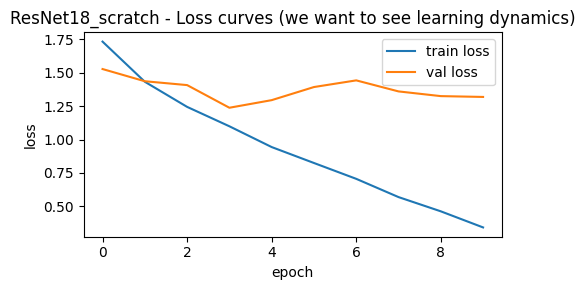

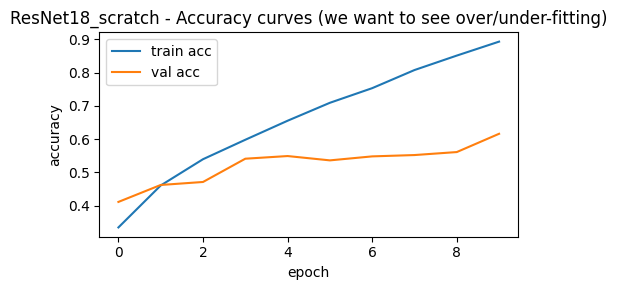

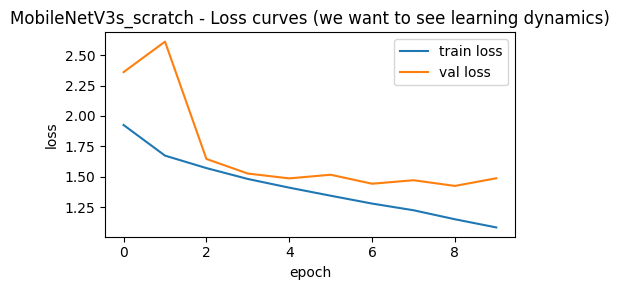

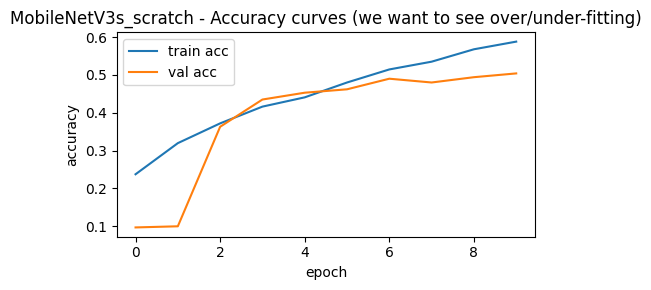

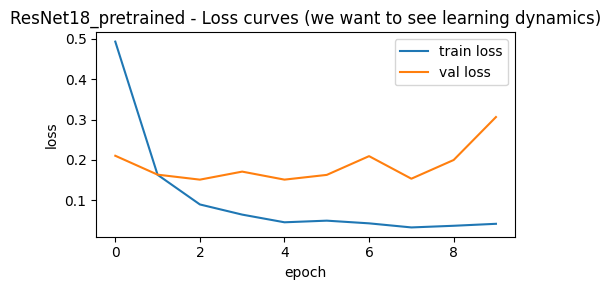

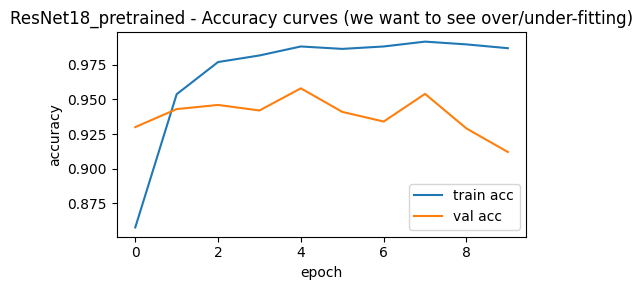

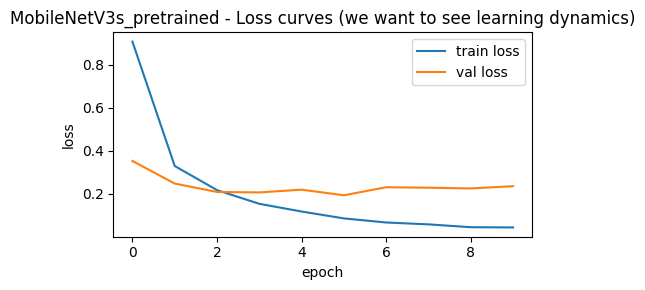

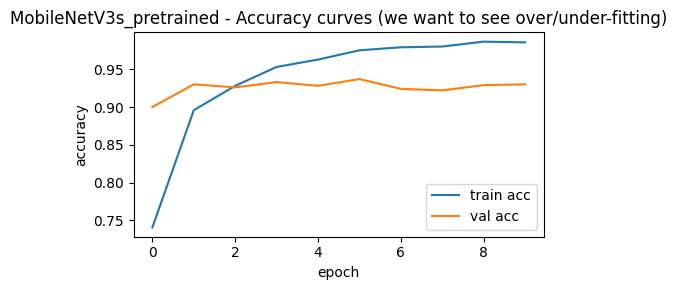

[ResNet18_scratch [TEST]] Acc=0.612 | Prec=0.634 | Recall=0.612 | F1=0.614 | mCA=0.612


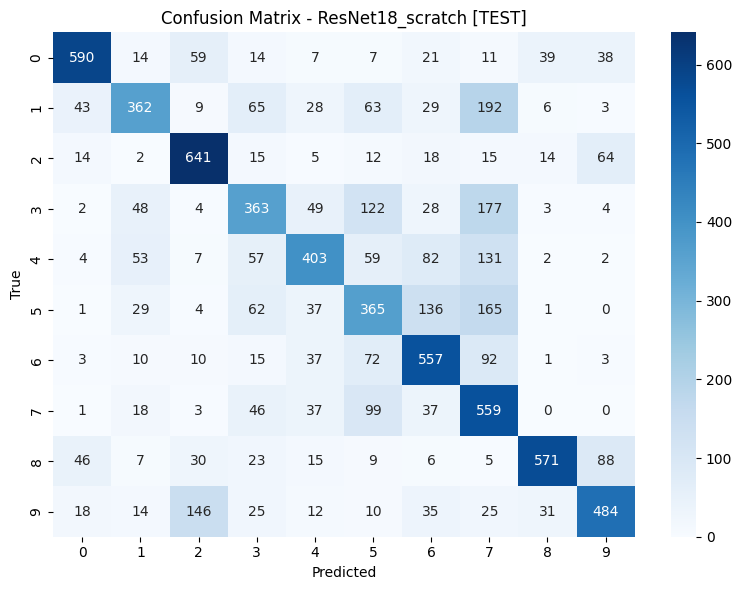

[MobileNetV3s_scratch [TEST]] Acc=0.497 | Prec=0.507 | Recall=0.497 | F1=0.486 | mCA=0.497


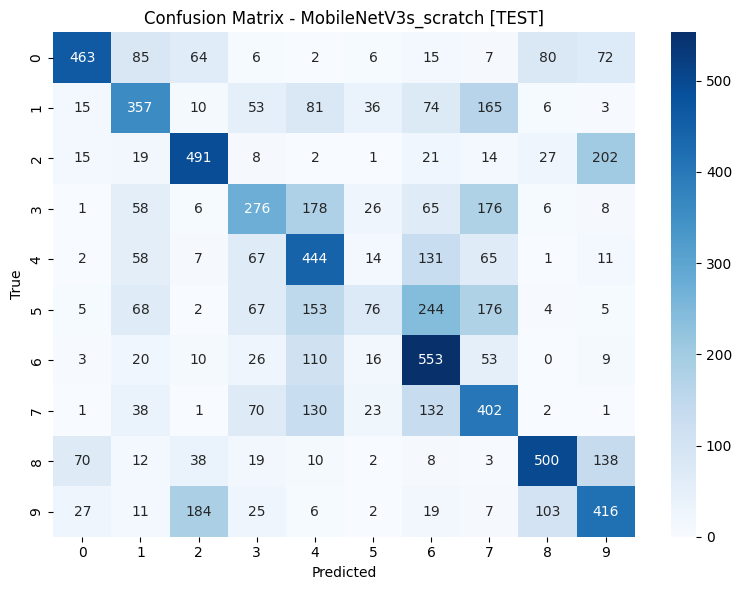

[ResNet18_pretrained [TEST]] Acc=0.944 | Prec=0.946 | Recall=0.944 | F1=0.944 | mCA=0.944


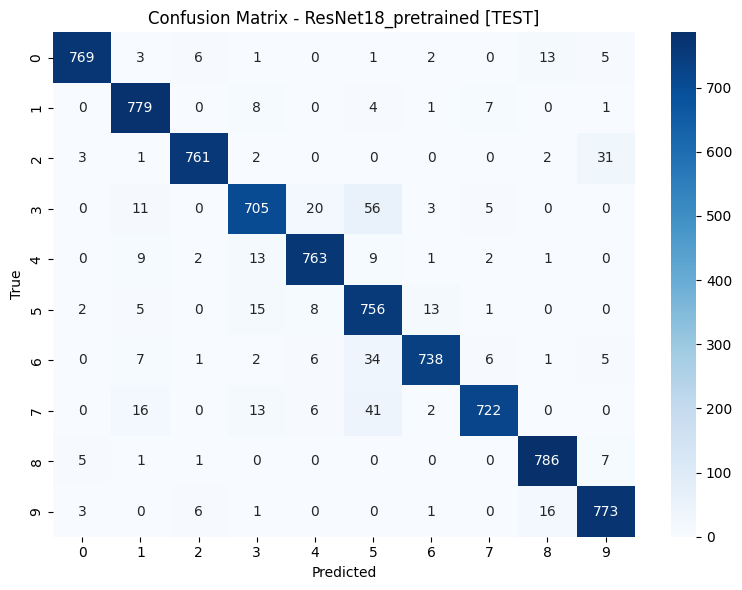

[MobileNetV3s_pretrained [TEST]] Acc=0.936 | Prec=0.937 | Recall=0.936 | F1=0.936 | mCA=0.936


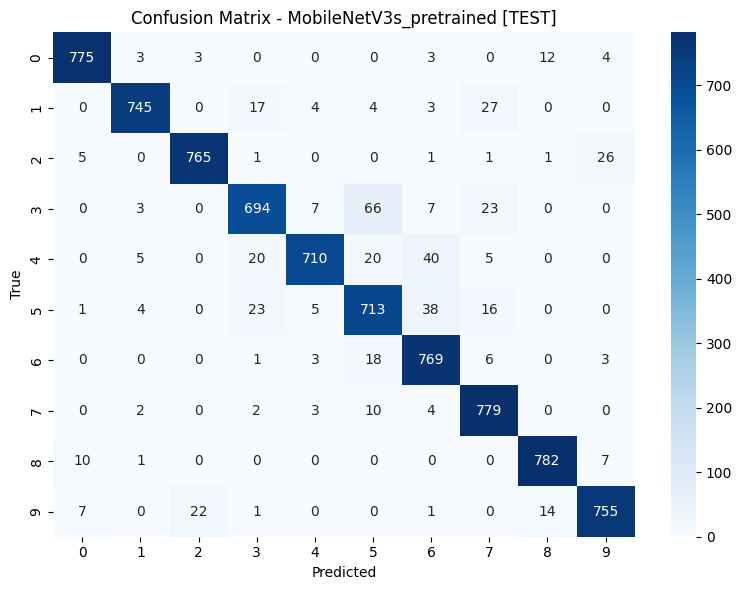

In [ ]:
# RUN for all four models
plot_curves(res_hist,        name="ResNet18_scratch")
plot_curves(mob_hist,        name="MobileNetV3s_scratch")
plot_curves(res_pre_hist,    name="ResNet18_pretrained")
plot_curves(mob_pre_hist,    name="MobileNetV3s_pretrained")

#evaluation metrics + confusion matrix — run on TEST
res_s_res   = evaluate_and_plot(resnet_scratch,   test_loader, name="ResNet18_scratch [TEST]")
mob_s_res   = evaluate_and_plot(mobilenet_scratch,test_loader, name="MobileNetV3s_scratch [TEST]")
res_p_res   = evaluate_and_plot(resnet_pre,       test_loader, name="ResNet18_pretrained [TEST]")
mob_p_res   = evaluate_and_plot(mobilenet_pre,    test_loader, name="MobileNetV3s_pretrained [TEST]")


In [ ]:
print(resnet_pre.layer4[-1].conv2.out_channels)

print(mobilenet_pre.features[-1][0].out_channels)


512
576


[MiddleFusion] Epoch [1/10] Train Acc: 0.976 | Val Acc: 0.963 | Train Loss: 0.3490 | Val Loss: 0.1875
[MiddleFusion] Epoch [2/10] Train Acc: 0.999 | Val Acc: 0.957 | Train Loss: 0.0637 | Val Loss: 0.1564
[MiddleFusion] Epoch [3/10] Train Acc: 0.998 | Val Acc: 0.964 | Train Loss: 0.0364 | Val Loss: 0.1347
[MiddleFusion] Epoch [4/10] Train Acc: 0.999 | Val Acc: 0.966 | Train Loss: 0.0239 | Val Loss: 0.1285
[MiddleFusion] Epoch [5/10] Train Acc: 0.999 | Val Acc: 0.963 | Train Loss: 0.0182 | Val Loss: 0.1258
[MiddleFusion] Epoch [6/10] Train Acc: 1.000 | Val Acc: 0.965 | Train Loss: 0.0142 | Val Loss: 0.1182
[MiddleFusion] Epoch [7/10] Train Acc: 0.999 | Val Acc: 0.967 | Train Loss: 0.0129 | Val Loss: 0.1080
[MiddleFusion] Epoch [8/10] Train Acc: 1.000 | Val Acc: 0.965 | Train Loss: 0.0090 | Val Loss: 0.1157
[MiddleFusion] Epoch [9/10] Train Acc: 1.000 | Val Acc: 0.963 | Train Loss: 0.0081 | Val Loss: 0.1174
[MiddleFusion] Epoch [10/10] Train Acc: 1.000 | Val Acc: 0.961 | Train Loss: 0.006

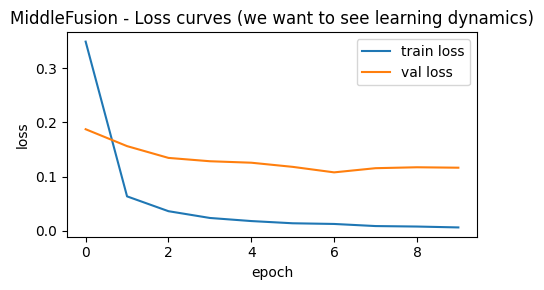

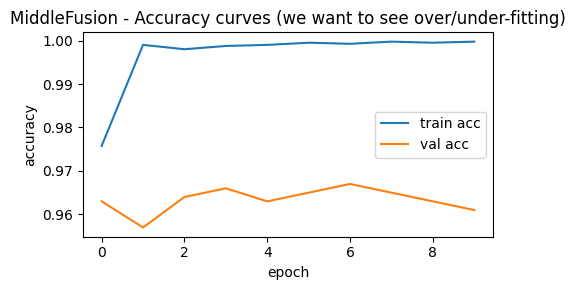

[MiddleFusion [TEST]] Acc=0.961 | Prec=0.960 | Recall=0.961 | F1=0.960 | mCA=0.961


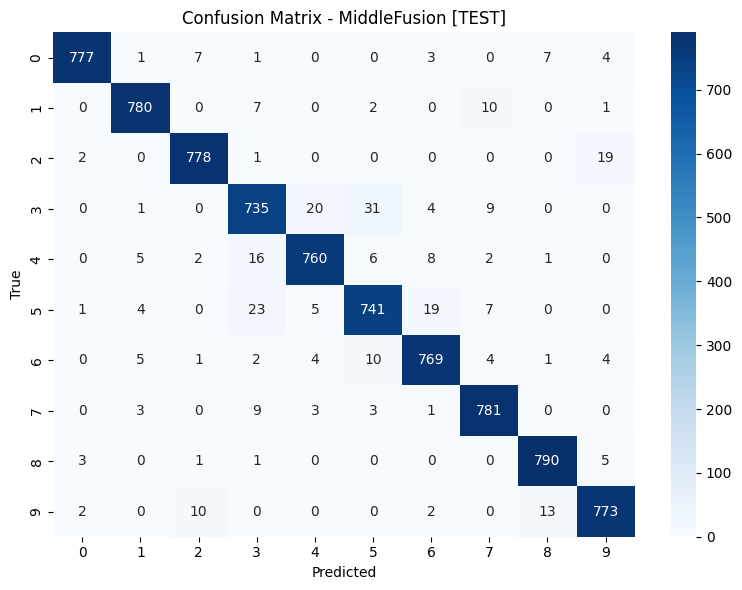

{'acc': 0.9605,
 'prec': 0.9604994205066841,
 'rec': 0.9605,
 'f1': 0.9604713362810108,
 'mCA': np.float64(0.9605),
 'cm': array([[777,   1,   7,   1,   0,   0,   3,   0,   7,   4],
        [  0, 780,   0,   7,   0,   2,   0,  10,   0,   1],
        [  2,   0, 778,   1,   0,   0,   0,   0,   0,  19],
        [  0,   1,   0, 735,  20,  31,   4,   9,   0,   0],
        [  0,   5,   2,  16, 760,   6,   8,   2,   1,   0],
        [  1,   4,   0,  23,   5, 741,  19,   7,   0,   0],
        [  0,   5,   1,   2,   4,  10, 769,   4,   1,   4],
        [  0,   3,   0,   9,   3,   3,   1, 781,   0,   0],
        [  3,   0,   1,   1,   0,   0,   0,   0, 790,   5],
        [  2,   0,  10,   0,   0,   0,   2,   0,  13, 773]])}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# build a fusion module that freezes backbones and concatenates features
class MiddleFusion(nn.Module):
    def __init__(self, resnet, mobilenet, num_classes=10):
        super().__init__()
        # we want the feature extractors (no final classifiers)
        self.res_feat = nn.Sequential(*list(resnet.children())[:-2])  # -> [B, 512, 7, 7]
        self.mob_feat = mobilenet.features                           # -> [B, 576, 7, 7]

        # freeze both backbones (as the PDF asks)
        for p in self.res_feat.parameters():
            p.requires_grad = False
        for p in self.mob_feat.parameters():
            p.requires_grad = False

        # keep backbones in eval mode forever (so BN stats won't change)
        self.res_feat.eval()
        self.mob_feat.eval()

        # infer channels from the actual models (robust across versions)
        res_ch = resnet.layer4[-1].conv2.out_channels      # 512
        mob_ch = mobilenet.features[-1][0].out_channels    # 576
        fused_ch = res_ch + mob_ch                         # 1088

        # a tiny fusion head: 1x1 conv to squeeze channels, then GAP -> Linear
        self.fuse = nn.Sequential(
            nn.Conv2d(fused_ch, 512, kernel_size=1, bias=False),  # we want to compress
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(512, num_classes)

    # make sure calling .train() will NOT flip backbones to train mode
    def train(self, mode: bool = True):
        super().train(mode)
        # we want backbones to stay in eval no matter what
        self.res_feat.eval()
        self.mob_feat.eval()
        return self

    def forward(self, x):
        # both backbones see the same image
        # we don't need grads for frozen parts (this saves memory and is faster)
        with torch.no_grad():
            fr = self.res_feat(x)   # [B, 512, H, W] ~ [B, 512, 7, 7]
            fm = self.mob_feat(x)   # [B, 576, H, W] ~ [B, 576, 7, 7]

        # we want same spatial size; with 224 input both are ~7x7, but let's be safe
        if fr.shape[-2:] != fm.shape[-2:]:
            H = min(fr.shape[-2], fm.shape[-2])
            W = min(fr.shape[-1], fm.shape[-1])
            fr = nn.functional.adaptive_avg_pool2d(fr, (H, W))
            fm = nn.functional.adaptive_avg_pool2d(fm, (H, W))

        f = torch.cat([fr, fm], dim=1)  # concat along channels -> [B, 1088, H, W]
        z = self.fuse(f)                # [B, 512, H, W]
        z = self.pool(z)                # [B, 512, 1, 1]
        z = torch.flatten(z, 1)         # [B, 512]
        out = self.head(z)              # [B, 10]
        return out


resnet_pre.load_state_dict(torch.load("best_resnet18_pretrained.pth"))
mobilenet_pre.load_state_dict(torch.load("best_mobilenetv3s_pretrained.pth"))

fusion = MiddleFusion(resnet_pre, mobilenet_pre, num_classes=10).to(device)

# train ONLY the new layers ; backbones are frozen
params_to_train = list(fusion.fuse.parameters()) + list(fusion.head.parameters())
opt_fuse = optim.Adam(params_to_train, lr=1e-4)  # we keep it simple and fair

# train with existing train_model
fusion_hist = train_model(
    fusion, opt_fuse,
    train_loader, val_loader,
    epochs=10, name="MiddleFusion"
)

# save the best fusion weights for safety
if fusion_hist["best_state"] is not None:
    torch.save(fusion_hist["best_state"], "best_middlefusion.pth")

# curves + test evaluation
plot_curves(fusion_hist, name="MiddleFusion")                 # we want to see loss/acc curves
evaluate_and_plot(fusion, test_loader, name="MiddleFusion [TEST]")  # metrics + CM on TEST
